<a href="https://colab.research.google.com/github/tejaswishetty17/Agentic-AI/blob/main/Calling_Agents_6(Maintaining%20running%20summary).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chat with message summarization

**Maintaining running summary**


>Lets say if the number of messages are growing beyond a certain threshold then summarize the conversation to maintain the contex. This allows us to reatain a compressed representation of the full conversation, rather than just removing it with filtering. This reduce the number of tokens on each queries sent to the LLM.

>Lets incorporate this summarization into a simple Chatbot.
And we'll equip that Chatbot with memory, supporting long-running conversation without incurring high token cost/latency


In [1]:
pip install -q langchain langchain_openai langchain_community langgraph langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 687.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.3 MB/s eta 0:00:00


In [2]:
import os
os.environ["OPENAI_API_KEY"] = "add your key"

In [3]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

> We'll use `MessageState`, as before.
In addition to the built-in `messages` key, we'll now include custom key (`summary`)

In [4]:
from langgraph.graph import MessagesState
class State(MessagesState):
  summary:str

> We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

#Define the logic to call the model
def call_model(state: State) -> State:

  #get summary if it exists
  summary = state.get("summary", "")

  #If there is summmary, then we do this
  if summary:

    #Add summary to system message
    system_message = f"Summary of conversation earlier: {summary}"

    #Apend summary to any newer messages
    messages = [SystemMessage(content=system_message)] + state["messages"]

  else:
    messages = state["messages"]

  response = model.invoke(messages)
  return {"messages":response}

> We'll define a node to produce a summary

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary


In [12]:
def summarize_conversation(state: State):

  #First, we get any existing summary
  summary = state.get("summary", "")

  #Create our summarization prompt
  if summary:

    # if summary already exists
    summary_message = (
        f"This is summary of the conversation to date: {summary}\n\n"
        "Extend the summary by taking into account the new messages above:"
    )
  else:
    summary_message = "Create a summary of the conversation above:"

  #Add prompt to our history
  messages = state["messages"] + [HumanMessage(content=summary_message)]
  response = model.invoke(messages)

  #Delete all but the 2 most recent messages
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
  return {"summary": response.content, "messages":delete_messages}


> We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [28]:
from langgraph.graph import END
#Determine whether to end or summarize the conversation
def should_continue(state: State)->State:
  """Return the next node to execute. """

  messages = state["messages"]

  # If there are more than six messages, then we summarize the conversation
  if len(messages)>6:
    return "summarize_conversation"
  # Otherwise we can just end
  return END

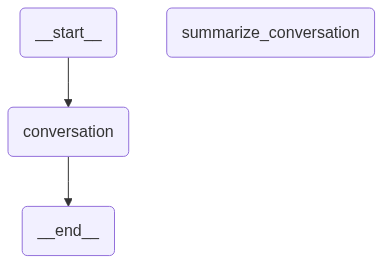

In [35]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
#create a thread
config = {"configurable": {"thread_id":"1"}}

#State conversation
input_message = HumanMessage(content = "Hi! I am Tejaswi")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
  m.pretty_print()

input_message = HumanMessage(content = "What is the LLM?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
  m.pretty_print()

input_message = HumanMessage(content = "I would like to know more about the use cases of LLM?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
  m.pretty_print()

================================== Ai Message ==================================

Hi Tejaswi! How can I assist you today?
================================== Ai Message ==================================

LLM stands for "Large Language Model." It refers to a type of artificial intelligence model that is trained on vast amounts of text data to understand and generate human-like language. These models use deep learning techniques, particularly neural networks, to process and generate text based on the patterns they learn during training.

Some key features of LLMs include:

1. **Natural Language Understanding**: They can comprehend and respond to text inputs in a way that mimics human conversation.

2. **Text Generation**: LLMs can generate coherent and contextually relevant text, making them useful for applications like chatbots, content creation, and more.

3. **Versatility**: They can perform a variety of language-related tasks, such as translation, summarization, question answering, a

Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`.

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [16]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [17]:
input_message = HumanMessage(content = "how do I use Langchain while using LLMs?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
  m.pretty_print()

================================== Ai Message ==================================

LangChain is a framework designed to facilitate the development of applications that utilize Large Language Models (LLMs). It provides tools and abstractions to help you build applications that can interact with LLMs more effectively. Here’s a general guide on how to use LangChain with LLMs:

### 1. **Installation**

First, you need to install LangChain. You can do this using pip:

```bash
pip install langchain
```

### 2. **Setting Up an LLM**

LangChain supports various LLMs, including OpenAI's GPT models, Hugging Face models, and others. You need to set up the LLM you want to use. For example, if you are using OpenAI's GPT-3 or GPT-4, you will need an API key.

Here’s how to set up an OpenAI LLM:

```python
from langchain.llms import OpenAI

# Initialize the OpenAI LLM
llm = OpenAI(api_key='your_openai_api_key')
```

### 3. **Creating a Chain**

LangChain allows you to create chains that define how inp

In [18]:
graph.get_state(config).values.get("summary","")

"In this conversation, you inquired about Large Language Models (LLMs) and their use cases. I provided an overview of LLMs, explaining their capabilities in natural language understanding, text generation, and various applications such as chatbots, content creation, translation, summarization, and more.\n\nYou then asked about using LangChain with LLMs. I outlined the steps to get started with LangChain, including installation, setting up an LLM (specifically OpenAI's models), creating a chain with a prompt template, and using that chain to generate responses. I also mentioned advanced features like memory and agents, and provided a brief example of using memory in a conversation. Finally, I suggested referring to the LangChain documentation for more detailed information and community support."